In [1]:
#importing libraries for coding
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
import contextily as ctx
import folium
from shapely.geometry import Point
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import re

In [14]:
munistops = gpd.read_file('data/Muni Stops_20250119.zip')
munistops.sample(1)

,objectid,stopname,trapezesto,rucusstopa,stopid,latitude,longitude,accessibil,atstreet,onstreet,...,shelter,insert_tim,sde_id,signupid,supervisor,date_data_,time_data_,date_dat_2,time_dat_2,geometry
750,73482.0,Diamond St&Diamond Heights Blvd NW-NS/SB,DIAMDI.0,DIAMDI.H,4397.0,37.74192,-122.435476,NaN,DIAMOND HEIGHTS BLVD,DIAMOND ST,...,0.0,1729767266000,15729734.0,147.0,8,2024-11-02,20:47:21.000,2024-11-04,09:42:39.000,POINT (-122.43548 37.74192)


In [15]:
munistops.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3285 entries, 0 to 3284
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   objectid    3285 non-null   float64       
 1   stopname    3285 non-null   object        
 2   trapezesto  3285 non-null   object        
 3   rucusstopa  2930 non-null   object        
 4   stopid      3285 non-null   float64       
 5   latitude    3285 non-null   float64       
 6   longitude   3285 non-null   float64       
 7   accessibil  657 non-null    float64       
 8   atstreet    3194 non-null   object        
 9   onstreet    3274 non-null   object        
 10  position    2922 non-null   object        
 11  orientatio  2944 non-null   object        
 12  servicepla  1646 non-null   object        
 13  shelter     3285 non-null   float64       
 14  insert_tim  3285 non-null   object        
 15  sde_id      3285 non-null   float64       
 16  signupid    3285

In [16]:
desired_columns=['stopname', 'latitude', 'longitude', 'geometry']
munistops=munistops[desired_columns]
munistops.sample()

,stopname,latitude,longitude,geometry
2758,The Embarcadero&Washington St SW,37.796355,-122.395181,POINT (-122.39518 37.79636)


<Axes: >

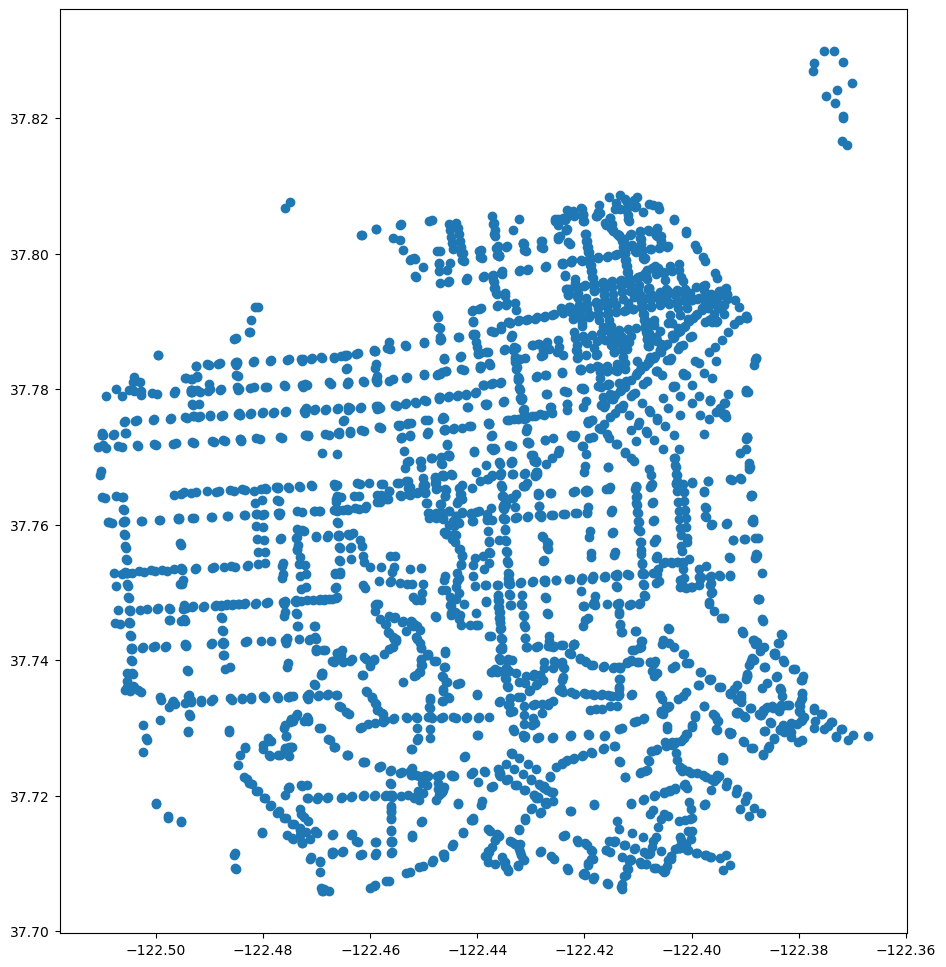

In [19]:
munistops.plot(
    figsize=(20,12)
)

In [5]:
# importing schools file
schools = gpd.read_file('data/public_hs.csv')
schools

,Campus Name,CCSF Entity,Grade Range,Location 1
0,"Marshall, Thurgood Marshall High School",SFUSD,9-12,"(37.735676, -122.401888)"
1,"Burton, Phillip And Sala Burton High School",SFUSD,9-12,"(37.720628, -122.405299)"
2,"Washington, George Washington High School",SFUSD,9-12,"(37.777851, -122.492040)"
3,"Lincoln, Abraham Lincoln High School",SFUSD,9-12,"(37.747810, -122.481411)"
4,Gateway High School / Kipp Sf Bay Academy,SFUSD,9-12,"(37.783140, -122.437727)"
5,Galileo High School,SFUSD,9-12,"(37.803410, -122.423994)"
6,Balboa High School,SFUSD,9-12,"(37.721418, -122.440282)"
7,City Arts And Leadership High School,SFUSD,9-12,"(37.721384, -122.445052)"
8,Independence High School,SFUSD,9-12,"(37.763329, -122.464052)"
9,"Wallenberg, Raoul Wallenberg High School",SFUSD,9-12,"(37.780102, -122.446239)"


In [22]:
schools['latitude'] = schools['Location 1'].apply(lambda x: float(x.strip('()').split(',')[0]))
schools['longitude'] = schools['Location 1'].apply(lambda x: float(x.strip('()').split(',')[1]))

# Step 3: Create Point objects from the extracted latitude and longitude values
schools['geometry'] = schools.apply(lambda row: Point(row['latitude'], row['longitude']), axis=1)

# Step 4: Assign the Point objects to a new geometry column in the GeoDataFrame
schools = gpd.GeoDataFrame(schools, geometry='geometry', crs='EPSG:4326')
schools.sample(1)

,Campus Name,CCSF Entity,Grade Range,Location 1,latitude,longitude,geometry
7,City Arts And Leadership High School,SFUSD,9-12,"(37.721384, -122.445052)",37.721384,-122.445052,POINT (37.72138 -122.44505)


In [21]:
import geopandas as gpd
from shapely.geometry import Point
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import contextily as ctx
import re

# Assuming your GeoDataFrame is named 'schools' and the column with lat/long is 'Location 1'
# Step 1: Import the necessary libraries
import geopandas as gpd
from shapely.geometry import Point

# Step 2: Extract the latitude and longitude values from the "Location 1" column
# Assuming the format is like (37.736309, -122.401649)
schools['latitude'] = schools['Location 1'].apply(lambda x: float(x.strip('()').split(',')[0]))
schools['longitude'] = schools['Location 1'].apply(lambda x: float(x.strip('()').split(',')[1]))

# Step 3: Create Point objects from the extracted latitude and longitude values
schools['geometry'] = schools.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)

# Step 4: Assign the Point objects to a new geometry column in the GeoDataFrame and set the CRS to WGS 84
schools = gpd.GeoDataFrame(schools, geometry='geometry', crs='EPSG:4326')

# Ensure munistops has a CRS set before converting it to the CRS of schools
if munistops.crs is None:
    munistops.set_crs('EPSG:4326', inplace=True)  # Assuming the original CRS is WGS 84

# Convert munistops to the same CRS as schools
munistops = munistops.to_crs(schools.crs)

# Define the schools_walking_map function
def schools_walking_map(school, place, munistops):
    latlon = school.geometry.coords[0][::-1]  # Reverse the order to get (latitude, longitude)
    network_type = 'walk' 
    trip_times = [5, 10, 15] 
    meters_per_minute = 75 

    # Manually set the CRS to epsg:4326 for the graph
    G = ox.graph_from_point(latlon, network_type=network_type, dist=2000, simplify=True, custom_filter=None)
    G = ox.project_graph(G, to_crs='epsg:3857')
    gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)

    minx, miny, maxx, maxy = gdf_nodes.geometry.total_bounds
    centroid_x = (maxx - minx) / 2 + minx
    centroid_y = (maxy - miny) / 2 + miny

    center_node = ox.distance.nearest_nodes(G, Y=centroid_y, X=centroid_x)

    gdf_edges['walk_time'] = gdf_edges['length'] / meters_per_minute

    cmap = 'RdYlGn'
    iso_colors = ox.plot.get_colors(n=len(trip_times), cmap=cmap, start=0)

    time_color = list(zip(trip_times, iso_colors))
    time_color.reverse()

    for time, color in list(time_color):
        # for each trip time, create an egograph of nodes that fall within that distance
        subgraph = nx.ego_graph(G, center_node, radius=time, distance='walk_time')

        # for each of those nodes, update the gdf_nodes dataframe and assign it with its associated distance color
        for node in subgraph.nodes():
            gdf_nodes.loc[node, 'time'] = time
            gdf_nodes.loc[node, 'color'] = color

    gdf_nodes['color'] = gdf_nodes['color'].fillna('#cccccc')

    isochrones = gdf_nodes.dissolve(by="time")
    isochrones = isochrones.convex_hull.reset_index(name='geometry')
    isochrones.sort_values(by='time', ascending=False, inplace=True)
    iso_colors = ['#f7fcb9', '#addd8e', '#31a354']

    fig, ax = plt.subplots(figsize=(10, 15))

    # add the isochrone boundary
    isochrones.boundary.plot(
        ax=ax,
        alpha=1,
        linestyle='--',
        color=iso_colors,
        lw=2
    )

    # add the isochrones
    isochrones.plot(
        ax=ax,
        alpha=0.2,
        categorical=True,  # even though it is numeric, treat it as categorical
        color=iso_colors,
    )

    # add the center node in red
    gdf_nodes.loc[[center_node]].plot(
        ax=ax,
        color='r',
        marker='x',
        markersize=50
    )

    # Debug: Print bounds and centroid to understand the issue
    print(f"Bounds: {gdf_nodes.total_bounds}")
    print(f"Centroid: ({centroid_x}, {centroid_y})")

    # Ensure CRS of munistops matches CRS of isochrones before spatial join
    munistops = munistops.to_crs(isochrones.crs)

    # Debug: Print CRS to ensure they match
    print(f"munistops CRS: {munistops.crs}")
    print(f"isochrones CRS: {isochrones.crs}")

    # Add transit stops within the isochrone area
    transit_stops_within_isochrone = gpd.sjoin(munistops, isochrones, predicate='intersects')
    
    # Debug: Print the transit stops within isochrone to understand the issue
    print(f"Transit stops within isochrone: {transit_stops_within_isochrone}")

    if not transit_stops_within_isochrone.empty:
        transit_stops_within_isochrone.plot(
            ax=ax,
            color='blue',
            markersize=10,
            label='Transit Stop'
        )

    # Set the aspect ratio manually to avoid ValueError
    ax.set_aspect('equal')

    # build custom legend
    legend_elements = [
        # add the center node to the legend
        Line2D([0], [0], marker='x', color='red', linestyle='', label='Start location', markersize=6),
        # add the transit stops within isochrone to the legend
        Line2D([0], [0], marker='o', color='blue', linestyle='', label='Transit Stop', markersize=6)
    ]

    # sort back to small time to large time
    # time_color.sort(reverse=False)
    time_color.reverse()

    # loop through the list of time/colors and add each to the legend
    for time, color in list(time_color):
        legend_item = Patch(facecolor=color, edgecolor=color, linestyle='--', linewidth=1, label=str(time) + ' minutes', alpha=0.4)
        legend_elements.append(legend_item)

    # add the legend
    ax.legend(handles=legend_elements, loc='lower left')  # location options: upper/center/lower and left/center/right

    # add a title
    ax.set_title(f'How far can you walk from {place}?', fontsize=25, pad=20)

    # hide the axis
    ax.axis('off')

    # add the basemap
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

    # Sanitize the place string to create a valid filename
    sanitized_place = re.sub(r'[^a-zA-Z0-9]', '_', place)

    # Save the figure
    plt.savefig(f'{sanitized_place}_walking_map.png')
    plt.close()

# Iterate over each unique location and create a map
for idx, school in schools.iterrows():
    place = school['Campus Name']  # Replace with the actual column name for the school name
    schools_walking_map(school, place, munistops)

Bounds: [-13628247.23838399   4539622.31083674 -13623184.28322737
   4544684.10503905]
Centroid: (-13625715.760805683, 4542153.207937896)
munistops CRS: epsg:3857
isochrones CRS: epsg:3857
Transit stops within isochrone:                                 stopname   latitude   longitude  \
40        Oakdale Ave&Toland St NE-NS/PS  37.740966 -122.401416   
161     Industrial St&Elmira St SE-FS/SB  37.738790 -122.403730   
205     Silver Ave&San Bruno Ave S-NS/BZ  37.732410 -122.405672   
205     Silver Ave&San Bruno Ave S-NS/BZ  37.732410 -122.405672   
225        Silver Ave&Revere Ave W-FS/PS  37.736361 -122.398888   
...                                  ...        ...         ...   
3038  Silver Ave&Charter Oak Ave N-NS/BZ  37.733275 -122.404297   
3075  San Bruno Ave&Thornton Ave E-NS/BZ  37.730260 -122.404620   
3180   Industrial St&Bayshore Blvd SE-FS  37.737943 -122.406780   
3209             Revere Ave&Lane St W-NS  37.731690 -122.390290   
3265      Newhall St&Oakdale Ave N-NS/SB  